In [1]:
import numpy             as np
import matplotlib.pyplot as plt

from matplotlib          import rcParams, rc
# Change the matplotlib default parameters
# rcParams.update({'font.size':   12})
rcParams.update({'figure.dpi': 200})
# rc('font', family='serif')
# rc('text', usetex=True)

from astropy import units as units

from src.odes           import ODE
from src.rates          import initialise_abs, calculate_rates, read_specs_file
from src.input          import setinput, getcst, density

from scipy.integrate    import solve_ivp
from astropy            import constants

specs, parnt, consv = read_specs_file('C')

specs_dict = dict()
for i in range(len(specs)):
    specs_dict[specs[i]] = i

In [2]:
specs_dict

{'H': 0,
 'H-': 1,
 'H+': 2,
 'H2+': 3,
 'H3+': 4,
 'He+': 5,
 'He': 6,
 'HeH+': 7,
 'C+': 8,
 'C': 9,
 'C-': 10,
 'CH': 11,
 'CH-': 12,
 'CH+': 13,
 'CH2': 14,
 'CH2+': 15,
 'N+': 16,
 'N': 17,
 'NH+': 18,
 'NH': 19,
 'CH3': 20,
 'CH3+': 21,
 'NH2+': 22,
 'O+': 23,
 'CH4+': 24,
 'NH2': 25,
 'O-': 26,
 'CH4': 27,
 'O': 28,
 'NH3': 29,
 'OH-': 30,
 'OH+': 31,
 'NH3+': 32,
 'CH5+': 33,
 'OH': 34,
 'NH4+': 35,
 'H2O': 36,
 'H2O+': 37,
 'F': 38,
 'H3O+': 39,
 'F+': 40,
 'HF': 41,
 'HF+': 42,
 'H2F+': 43,
 'Na+': 44,
 'Na': 45,
 'C2+': 46,
 'Mg+': 47,
 'Mg': 48,
 'C2-': 49,
 'C2': 50,
 'C2H': 51,
 'C2H+': 52,
 'C2H-': 53,
 'C2H2': 54,
 'C2H2+': 55,
 'CN': 56,
 'CN-': 57,
 'CN+': 58,
 'HNC': 59,
 'HCN': 60,
 'C2H3': 61,
 'C2H3+': 62,
 'HCN+': 63,
 'H2CN': 64,
 'CO+': 65,
 'Si+': 66,
 'N2+': 67,
 'Si': 68,
 'N2': 69,
 'C2H4': 70,
 'H2NC+': 71,
 'HCNH+': 72,
 'C2H4+': 73,
 'CO': 74,
 'SiH+': 75,
 'C2H5': 76,
 'HCO': 77,
 'SiH': 78,
 'HCO+': 79,
 'HOC+': 80,
 'C2H5+': 81,
 'N2H+': 82,
 'CH2NH':

In [2]:


## input values physics
def setinput(Mdot, vexp, r, T, δ, Av, chemtype):
    '''
    Set input values of the model.

    INPUT:
        - ρ  = density       [g/cm^3]
            via mass-loss rate (Mdot [Msol/yr]) & expansion velocity (vexp [km/s])
        - T  = temperature   [K]
        - δ  = outwards dilution of radiation field     == RAD
        - Av = outward dus extinction
        - chemtype = type of chemistry: 'C' or 'O'
    '''

    ## input physics
    ρ = density(Mdot, vexp, r)

    print('Input:')
    print('------')
    print('ρ  =','{:.2E}'.format(ρ))
    print('T  =',T)
    print('δ  =',δ)
    print('Av =',Av)
    print('')
    print('Chem type =', chemtype)

    return ρ, T, δ, Av, chemtype

def solve(ρ, T, δ, Av, chemtype, Δt):

    ## calculate H accretion on dust
    Haccr = stckH *np.pi*(rGr**2.0)*ρ*nGr*(8.0*kB*T/(np.pi*mH))**0.5

    ## set initial conditions
    n, nconsv_tot, specs = initialise_abs(chemtype)     # nconsv_tot = TOTAL in fortran code
    timesteps = 1

    ndot        = np.zeros(len(n))
    nconsv      = np.zeros(len(nconsv_tot))
    t           = np.zeros(timesteps)

    k = calculate_rates(T, δ, Av)

    Δt = Δt*yr_to_sec  ## in sec


    print(' >> Solving ODE ...')
    ## solve ODE
    solution = solve_ivp(
        fun          = ODE,
        t_span       = [0.0, Δt],
        y0           = n,
        method       = 'BDF',   ## zoals DVODE
        args         = (ndot, nconsv, nconsv_tot,k, ρ, Haccr),
        dense_output = False    ## if True: returns interpolation function
        )

    assert solution['status'] == 0

    ys = solution['y']
    ts = solution['t']

    print(solution['message'])

    return ts, ys

def plot(ts, ys):
    fig = plt.figure(figsize=(8,6))

    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212)
    axs = [ax1,ax2]

    for i in range(ys.shape[0]):
        ax1.plot(ts, ys[i])
        ax2.plot(ts, -ys[i])

    for ax in axs:
        ax.set_yscale('log')
        ax.set_xscale('log')

        # ax.set_ylim((1.0e-40, 1.0e+0))

    ax.set_xlabel('time [s]')
    ax1.set_ylabel('abundance')
    ax2.set_ylabel('negative abundance')

    plt.show()

    return

def search_negs(ys, elwise = False, el = None):
    idx_neg = list()

    if elwise == False:
        for i in range(ys.shape[0]):
            if np.any(ys[i] < 0):
                idx_neg.append(i)

    if elwise == True:
        for i in range(ys.shape[0]):
            if np.any(ys[i][el] < 0):
                idx_neg.append(i)


    specs_neg = list()

    for idx in idx_neg:
        specs_neg.append(specs[idx])

    return idx_neg, specs_neg

### Test simulations

In [3]:
## constants
kB, mH, rGr, nGr, stckH, AUV_AV = getcst()
yr_to_sec = units.year.to('s')         ## year in seconds

In [26]:
## Sim 1
ρ, T, δ, Av, chemtype = setinput(1.e-8, 5., 1.e15, 2500., 1., 1., 'C')
ts1, ys1 = solve(ρ, T, δ, Av, chemtype, 1.e1)

Input:
------
ρ  = 2.25E+04
T  = 2500.0
δ  = 1.0
Av = 1.0

Chem type = C
 >> Solving ODE ...
The solver successfully reached the end of the integration interval.


In [25]:
## Sim 2
ρ, T, δ, Av, chemtype = setinput(1.e-6, 15., 1.e15, 2500., 1., 1., 'O')
ts2, ys2 = solve(ρ, T, δ, Av, chemtype, 1.e1)

Input:
------
ρ  = 7.51E+05
T  = 2500.0
δ  = 1.0
Av = 1.0

Chem type = O
 >> Solving ODE ...
The solver successfully reached the end of the integration interval.


In [8]:
## Sim 3
ρ, T, δ, Av, chemtype = setinput(1.e-8, 5., 1.e15, 2500., 1., 1., 'O')
ts3, ys3 = solve(ρ, T, δ, Av, chemtype, 1.e1)

Input:
------
ρ  = 2.25E+04
T  = 2500.0
δ  = 1.0
Av = 1.0

Chem type = O
 >> Solving ODE ...
The solver successfully reached the end of the integration interval.


In [27]:
## Sim 4
ρ, T, δ, Av, chemtype = setinput(1.e-8, 5., 1.e15, 2500., 1.e-5, 0.5, 'O')
ts4, ys4 = solve(ρ, T, δ, Av, chemtype, 1.e1)

Input:
------
ρ  = 2.25E+04
T  = 2500.0
δ  = 1e-05
Av = 0.5

Chem type = O
 >> Solving ODE ...
The solver successfully reached the end of the integration interval.


/tmp/ipykernel_86906/3130051410.py:79: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


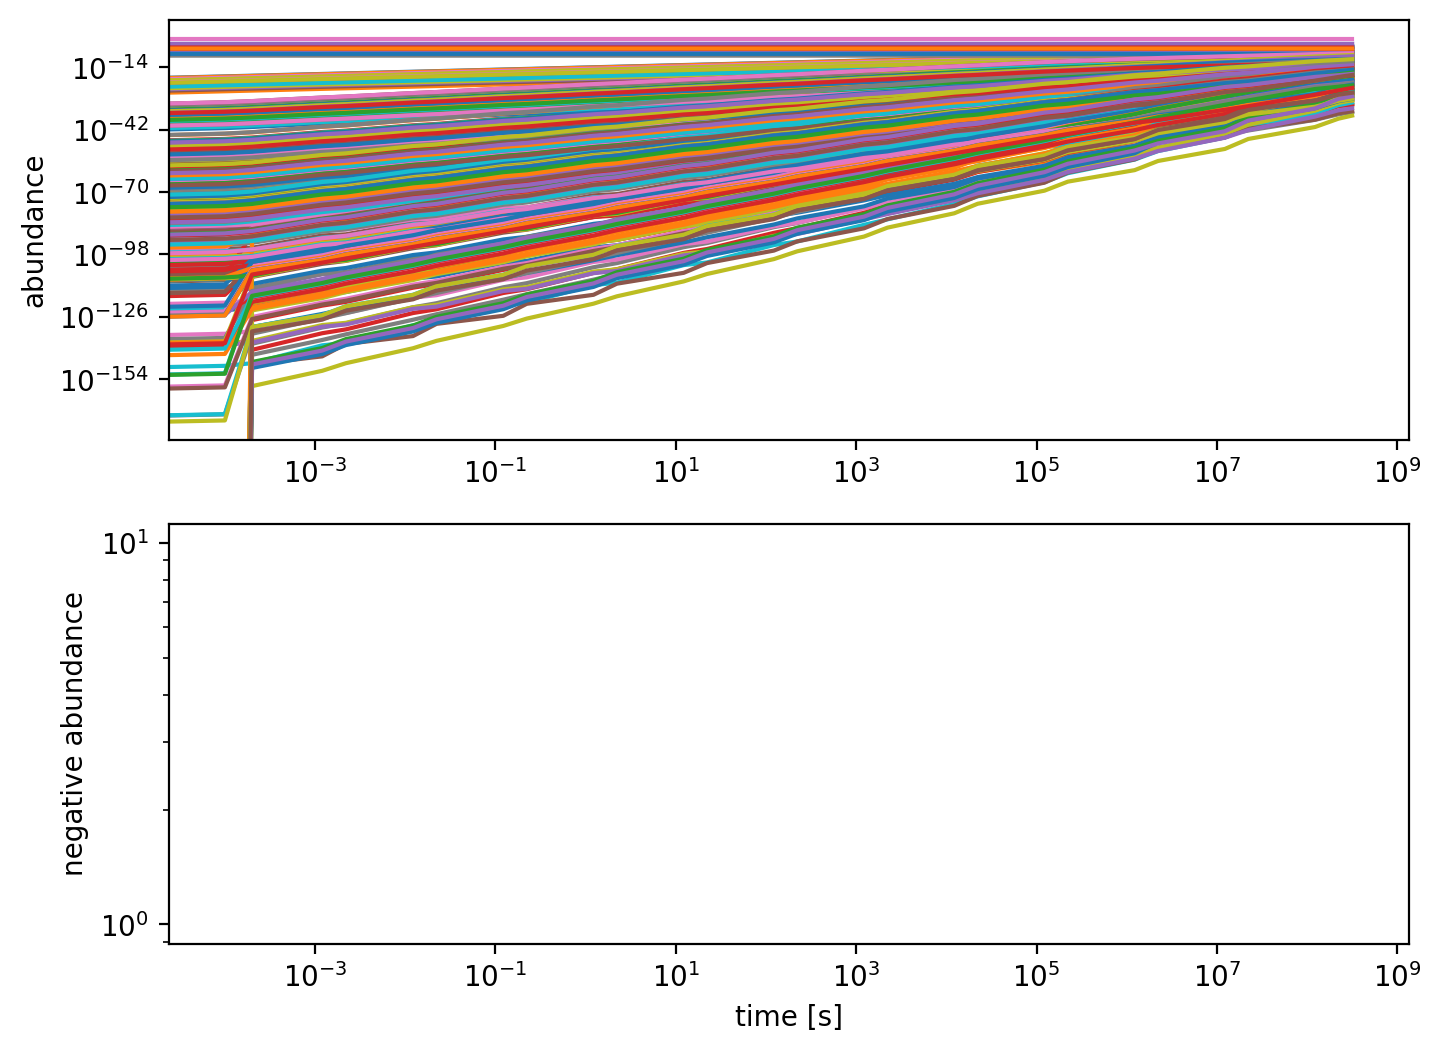

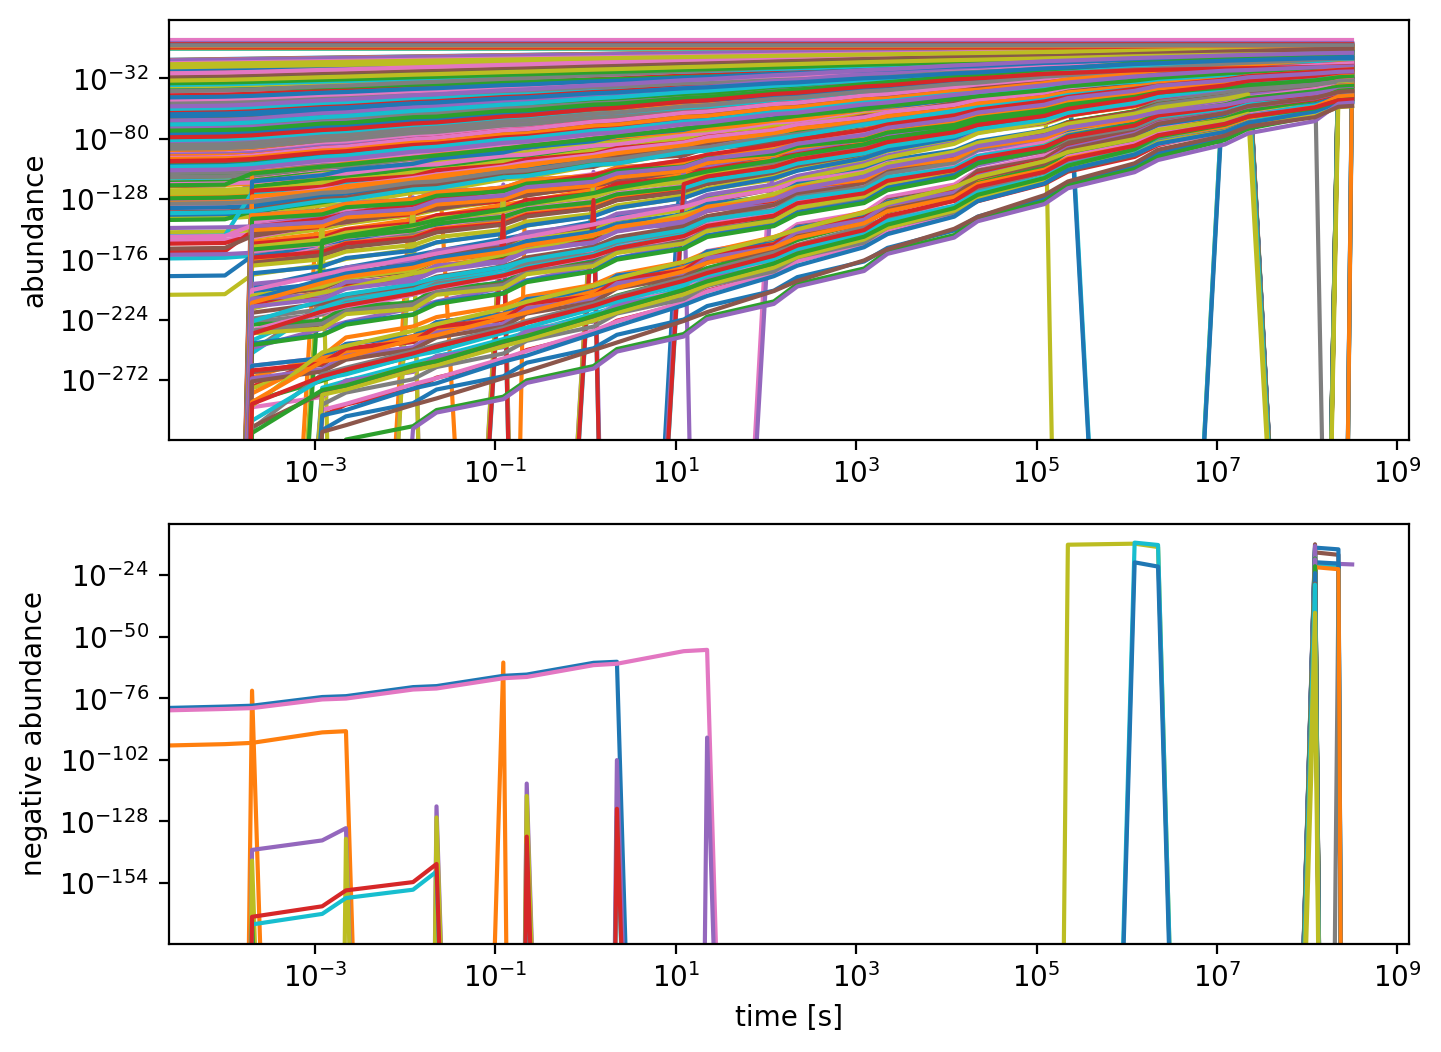

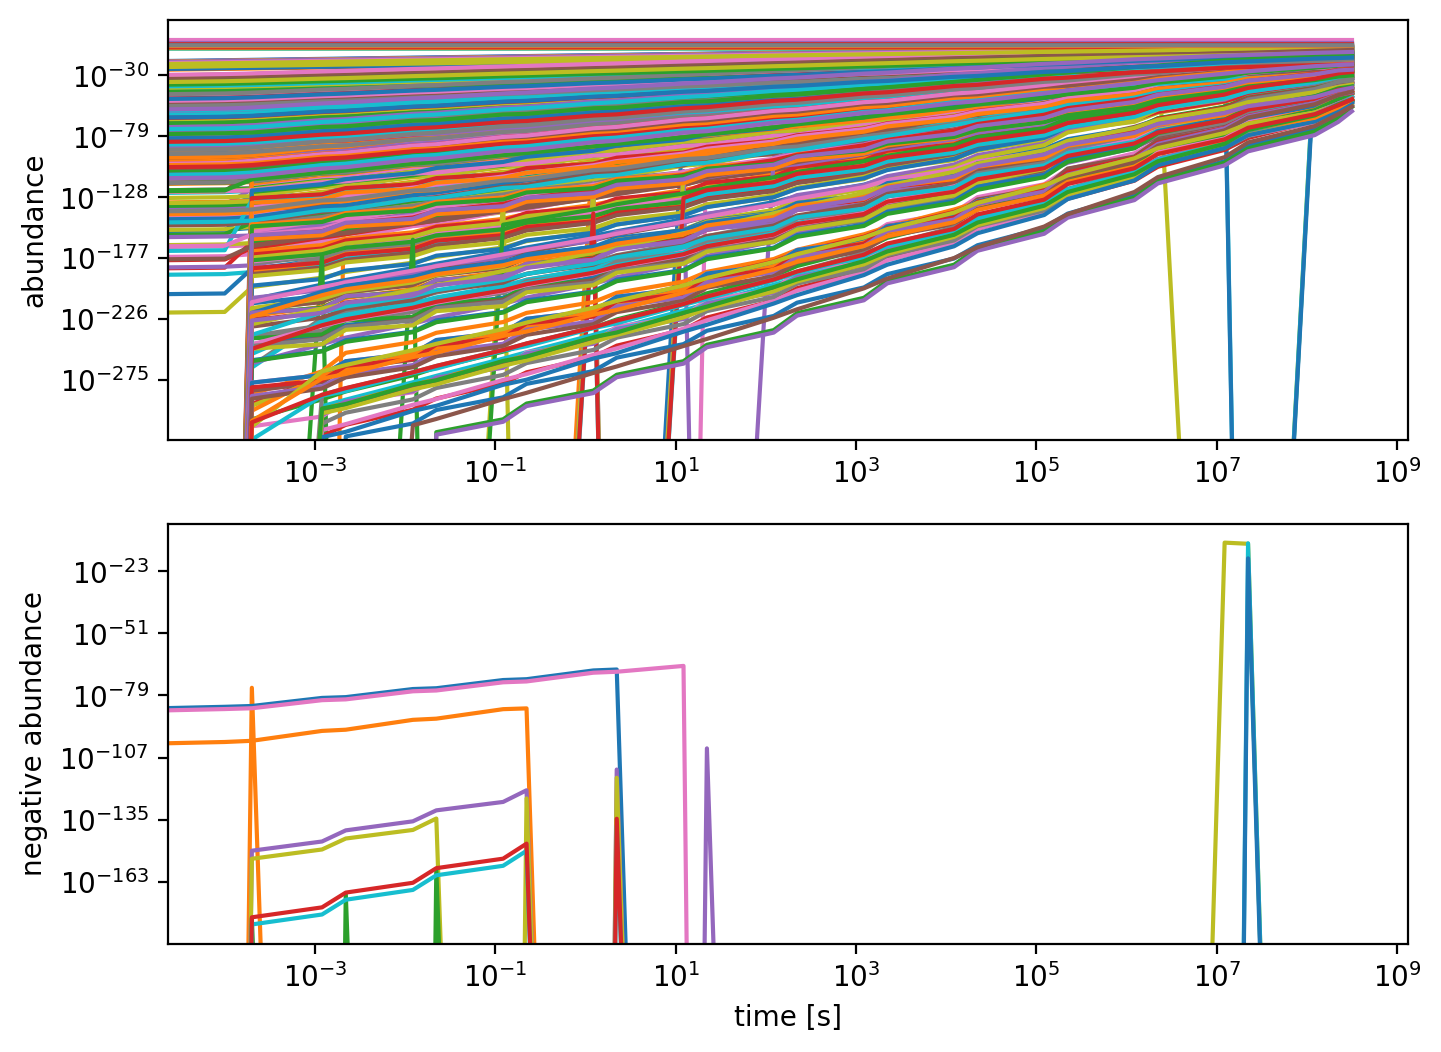

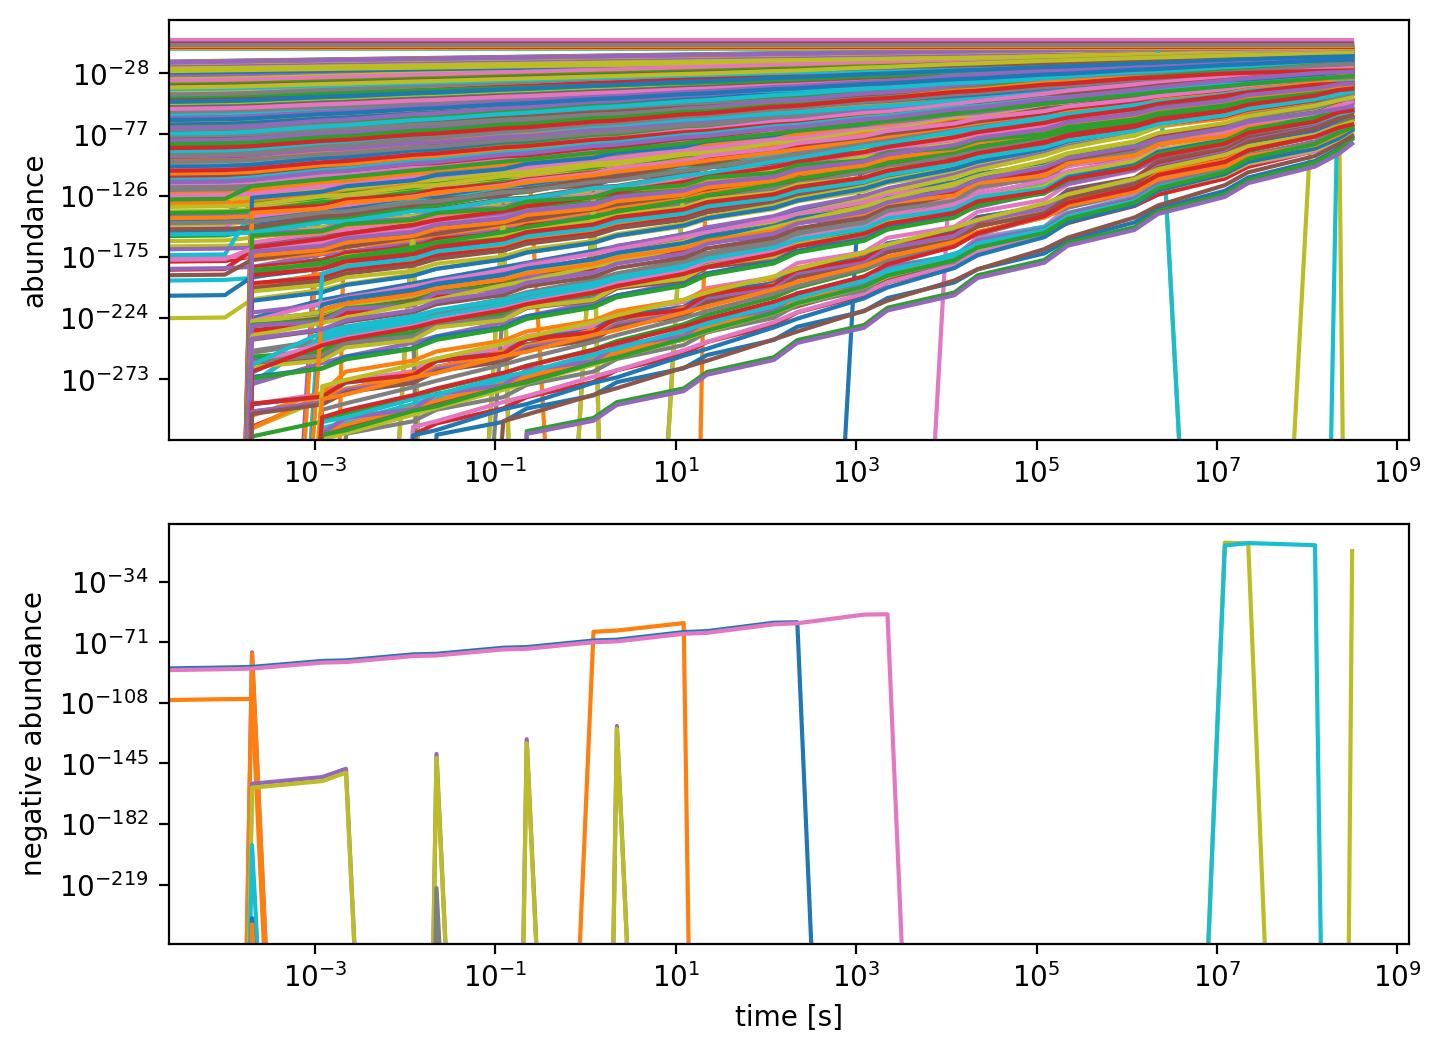

In [28]:
plot(ts1, ys1)
plot(ts2,ys2)
plot(ts3,ys3)
plot(ts4,ys4)

### Search for negatives

In [31]:
## ys1 - sim 1

idx_neg, specs_neg = search_negs(ys2)
print(len(idx_neg))
print(idx_neg)
print(specs_neg)

48
[38, 49, 52, 61, 70, 75, 76, 81, 91, 92, 95, 104, 107, 119, 129, 130, 133, 146, 152, 155, 160, 161, 165, 172, 217, 220, 230, 234, 250, 257, 262, 264, 274, 281, 297, 305, 312, 323, 340, 354, 365, 368, 369, 392, 399, 403, 418, 448]
['F', 'C2-', 'C2H+', 'C2H3', 'C2H4', 'SiH+', 'C2H5', 'C2H5+', 'CH2NH2+', 'H2CO', 'SiH3+', 'SiH4', 'SiH4+', 'SiH5+', 'Cl', 'Cl+', 'C3-', 'CH2CCH+', 'CH2CN', 'C3H4+', 'CH3CN', 'CH3CN+', 'CH2CO+', 'CH2CO', 'HN2O+', 'CH3CHOH+', 'H2CS+', 'H2CS', 'CH3OCH4+', 'PNH3+', 'H2PO+', 'H2CCl+', 'HC3N+', 'HC3NH+', 'C3H2O+', 'H3C3O+', 'C2H5CNH+', 'CH3COCH4+', 'H5C2O2+', 'SiC3', 'CH3C3NH+', 'C3P', 'NCCNCH3+', 'SiC4', 'C4P', 'C4S', 'CH3C5NH+', 'CH3C7NH+']


In [22]:
idx_neg, specs_neg = search_negs(ys1, elwise = True, el=1)
print('# negatives:',len(idx_neg))
for i in range(len(idx_neg)):
    print(idx_neg[i], specs_neg[i])

# negatives: 3
70 C2H4
76 C2H5
81 C2H5+


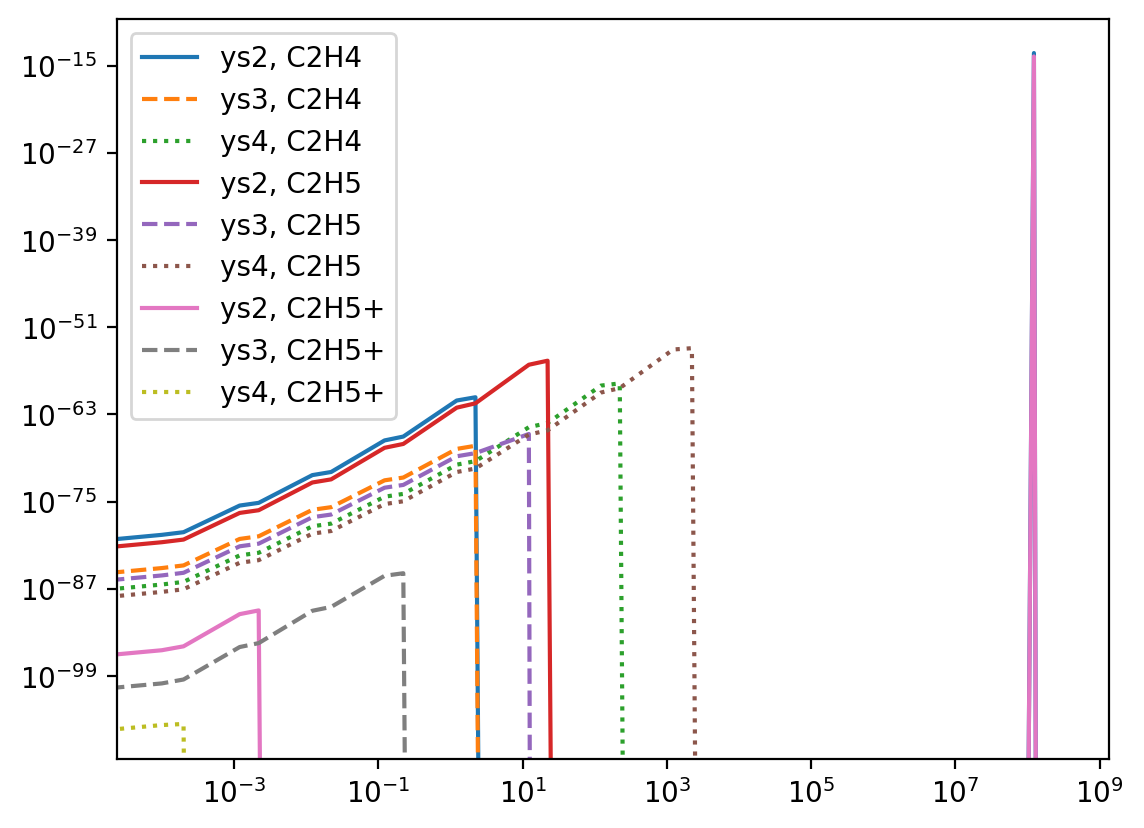

In [30]:
nbs = [38, 61, 70, 76, 81, 129, 130, 354, 368, 392, 399, 403]
nbs = [70,76,81]

for nb in nbs:
    # plt.loglog(ts3, -ys1[nb], label = "ys1, "+specs[nb]+', '+str(nb))
    plt.loglog(ts2, -ys2[nb], label = "ys2, "+specs[nb])
    plt.loglog(ts3, -ys3[nb], '--',label = "ys3, "+specs[nb])
    plt.loglog(ts4, -ys4[nb], ':',label = "ys4, "+specs[nb])
plt.legend(loc = 'upper left')
plt.show()

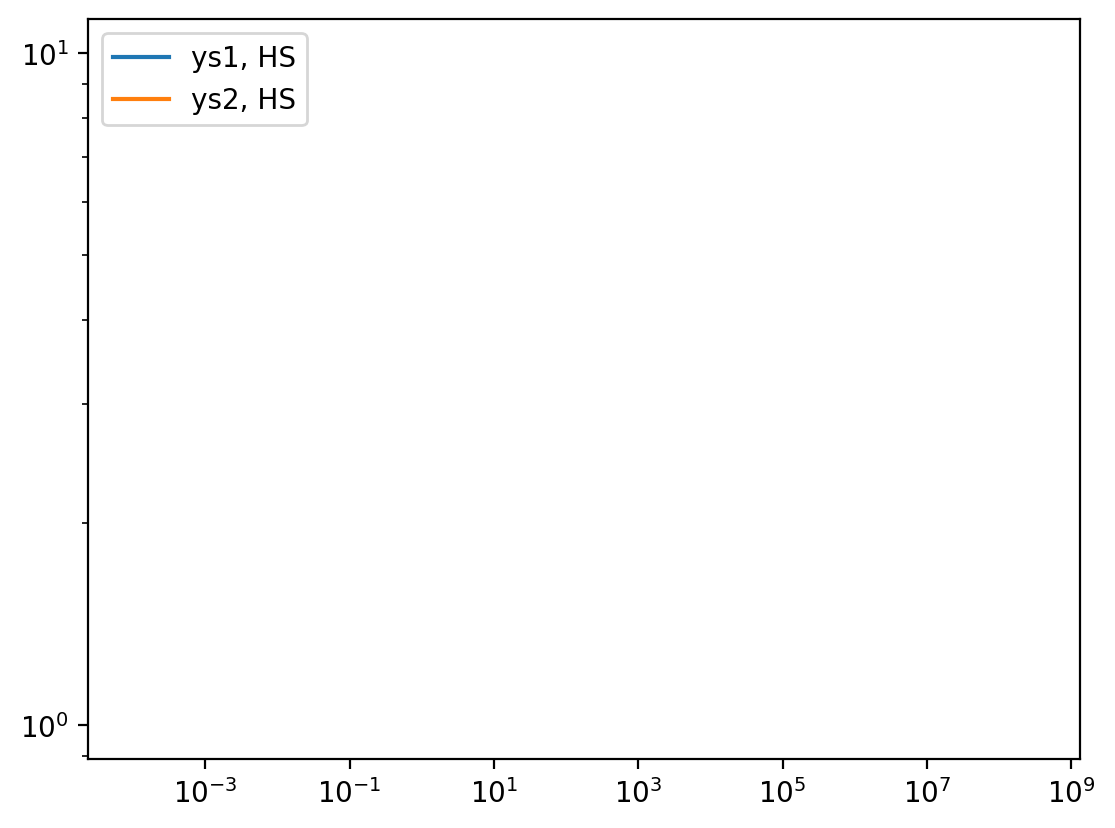

In [11]:
molecs = ['HS']

for molec in molecs:
    nb = specs_dict[molec]
    plt.loglog(ts1, -ys1[nb], label = "ys1, "+specs[nb])
    plt.loglog(ts2, -ys2[nb], label = "ys2, "+specs[nb])
    # plt.loglog(ts3, -ys3[nb], label = "ys3, "+specs[nb])
    # plt.loglog(ts4, -ys4[nb], label = "ys4, "+specs[nb])
plt.legend(loc = 'upper left')
plt.show()

In [54]:
ions = list()
for spec in specs:
    if spec[-1] == '+' or spec[-1] == '-':
        ions.append(spec)


In [55]:
len(ions)

296